### 环境准备：
- enviroments.yml 中 prefix 更改为自己虚拟环境的路径
- `conda env create --file enviroments.yml`

### ToDo:
- CPU并行处理 or GPU并行处理
- 画图
- 性能评估指标
- 进度条（尤指模型训练过程）
- 考虑使用稀疏矩阵（因为有大量的0填充）

### 调参：
soap算法中的参数
随机森林中的树的数目

如果调参调不出好的效果，考虑换算法（soap换成其他算法）,换模型（深度神经网络，使用pytorch）

### 其他：

#### 算法对比：
- soap算法擅长处理局部结构信息。
- Fingerprint算法擅长处理分子的相似性分析。

#### 调试技巧：
- dir查看有哪些方法和属性
- help查看详细信息
- pprint的用法:   `pprint(dir(networkx),indent=4,width=100,compact=True)`

### 数据预处理

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from ase.io import read
from pprint import pprint
import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from concurrent.futures import ProcessPoolExecutor, as_completed
zhfont1 = matplotlib.font_manager.FontProperties(fname='./font/SourceHanSansSC-Bold.otf')

with open('./data/supecon.csv', 'r') as file:
    data = pd.read_csv(file)
    pattern = r'([A-Z][a-z]?)(\d*)'
    elements = data['Formula'].str.findall(pattern).apply(lambda x: [match[0] for match in x])
    all_elements = set()
    all_elements.update(elements.explode().unique())
    all_elements = list(all_elements)
    # pprint(all_elements,indent=4,width=120,compact=True)
    cifs = data['cif']
    la = data['la']
    wlog = data['wlog']
    Tc_AD = data['Tc_AD']
    features = []
    labels = []
    # 创建标准化器对象
    scaler = StandardScaler()
    # 创建SOAP描述符对象
    soap = SOAP(
        species=all_elements,
        r_cut=5,# r_cut: 这是SOAP的截止距离，决定了参与计算的原子邻域的范围。选择合适的r_cut值可以影响计算的精度和效率。一般情况下，r_cut应根据原子之间的距离和体系的性质来选择，通常设置为5到10埃（Å）。
        n_max=1,# n_max: 表示考虑的原子数的最大数量。通常在体系较为复杂，原子数较多的情况下，n_max可以设置得较高。一般选择2到4就足够，因为过高的值可能增加计算成本而收益有限。
        l_max=1,# l_max: 这是球面谐函数的最大角量子数，它决定了描述电子环境的复杂程度。通常l_max值设置在3到6之间，具体取决于所需的描述精度。
        sigma=0.2,# sigma: 这是平滑化参数，影响SOAP描述符的平滑程度。较小的sigma可能会导致计算结果对局部结构变化敏感，而较大的sigma则可能使得描述符过于平滑而丢失细节。一般建议从0.1开始选择，根据结果进行调整。
        compression={"mode":"off","species_weighting":None},
        sparse=False,
        dtype='float32'
    )

# pprint(soap.get_number_of_features())
# pprint(dir(soap),indent=4,width=120,compact=True)
# help(soap.__repr__)


In [3]:
features = []
labels = []
for i in tqdm(range(len(cifs)),desc="读取并用ase解析cif文件,生成SOAP描述符"):
    cif_file = data.loc[i,"cif"]
    with open('temp_file.cif','w') as cif_output:
        cif_output.write(cif_file)
    atoms = read('temp_file.cif')
    soap_descriptors = scaler.fit_transform(np.array(soap.create(atoms),dtype=np.float32))  # 转换为numpy数组ndarray
    # 如果 soap.create(atoms) 返回的是一个稀疏数组
    # sparse_descriptors = soap.create(atoms)
    # dense_descriptors = sparse_descriptors.todense()  # 手动转换为密集数组
    # soap_descriptors = scaler.fit_transform(np.array(dense_descriptors, dtype=np.float64))

    features.append(soap_descriptors)
    # features.append(soap_descriptors.flatten())
    labels.append(data.loc[i,"Tc_AD"])
    # features是一个包含多个ndarray的列表
print(len(features))

读取并用ase解析cif文件,生成SOAP描述符: 100%|██████████| 8249/8249 [00:17<00:00, 460.10it/s]

8249


In [4]:
# 计算最大长度和宽度
max_length = max(feature.shape[0] for feature in features)
max_width = max(feature.shape[1] for feature in features)

# 填充特征
padded_features = np.array([
    np.pad(feature, ((0, max_length - feature.shape[0]), (0, max_width - feature.shape[1])), mode='constant')
    for feature in features
], dtype=features[0].dtype)

pprint(f'Padded features shape: {padded_features.shape}')

'Padded features shape: (8249, 12, 4290)'


In [5]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.3, random_state=42, shuffle=True)

# 将列表转换为 numpy 数组
X_train = np.reshape(np.array(X_train),(5774,-1))
X_test = np.reshape(np.array(X_test),(2475,-1))
y_train = np.array(y_train)
y_test = np.array(y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5774, 51480)
X_test shape: (2475, 51480)
y_train shape: (5774,)
y_test shape: (2475,)


### 训练模型

训练进度:   0%|          | 0/1 [1:25:06<?, ?it/s]
/home/poem/.conda/envs/soap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/poem/.conda/envs/soap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/poem/.conda/envs/soap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/poem/.conda/envs/soap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/poem/.conda/envs/soap/lib/python3.10/site-packages/IPyth

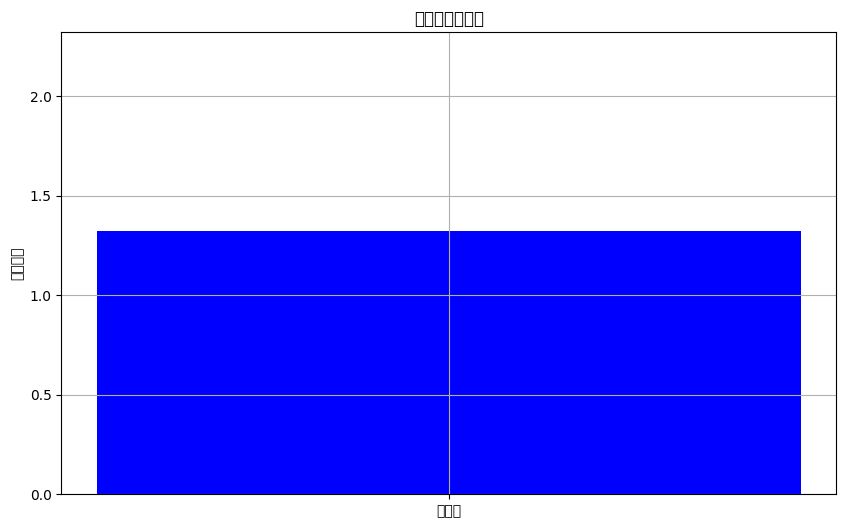

'测试集均方误差: 9.883270402017374'


In [6]:
# 创建随机森林模型
model = RandomForestRegressor(n_estimators=10, random_state=0)  # 树的数量在 100-1000 之间比较合适

# 使用 tqdm 包裹 fit 方法
mse_list = []
with tqdm(total=1, desc="训练进度") as pbar:
    # 训练模型
    model.fit(X_train, y_train)

# 进行预测
y_pred = model.predict(X_train)  # 可以预测训练集，方便计算 MSE
mse = mean_squared_error(y_train, y_pred)
mse_list.append(mse)

# 绘制训练后的 MSE（这里只记录了最终的MSE）
plt.figure(figsize=(10, 6))
plt.bar(['训练集'], mse_list, color='b')
plt.title('训练集均方误差')
plt.ylabel('均方误差')
plt.ylim(0, max(mse_list) + 1)
plt.grid()
plt.show()

# 评估模型性能
y_pred = model.predict(X_test)  # 预测测试集
mse_test = mean_squared_error(y_test, y_pred)

# 打印均方误差
pprint(f"测试集均方误差: {mse_test}")